In [137]:
import os
from six.moves import urllib
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer

In [138]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [139]:
# fetch data from its origin

def fetch_credit_crad_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_crad_data()

In [140]:
# load the dataset to pandas dataframe

def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    return pd.read_csv(csv_path, header=None)

credit_card_data = load_credit_card_data()

# get a quick view of the data

credit_card_data.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0,t,g,00000,0,-


In [141]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
0     690 non-null object
1     690 non-null object
2     690 non-null float64
3     690 non-null object
4     690 non-null object
5     690 non-null object
6     690 non-null object
7     690 non-null float64
8     690 non-null object
9     690 non-null object
10    690 non-null int64
11    690 non-null object
12    690 non-null object
13    690 non-null object
14    690 non-null int64
15    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


In [142]:
credit_card_data.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [143]:
credit_card_data.describe(include='O').T

,count,unique,top,freq
0,690,3,b,468
1,690,350,?,12
3,690,4,u,519
4,690,4,g,519
5,690,15,c,137
6,690,10,v,399
8,690,2,t,361
9,690,2,f,395
11,690,2,f,374
12,690,3,g,625


In [144]:
def get_unique_values(col):
    unique_values = credit_card_data[col].unique()
    unique_values_count = len(credit_card_data[col].unique())
    print (credit_card_data.columns.get_loc(col))
    print (unique_values)
    print(unique_values_count)

for col in credit_card_data:
    get_unique_values(col)
    print('\n')

0
['b' 'a' '?']
3


1
['30.83' '58.67' '24.50' '27.83' '20.17' '32.08' '33.17' '22.92' '54.42'
 '42.50' '22.08' '29.92' '38.25' '48.08' '45.83' '36.67' '28.25' '23.25'
 '21.83' '19.17' '25.00' '47.75' '27.42' '41.17' '15.83' '47.00' '56.58'
 '57.42' '42.08' '29.25' '42.00' '49.50' '36.75' '22.58' '27.25' '23.00'
 '27.75' '54.58' '34.17' '28.92' '29.67' '39.58' '56.42' '54.33' '41.00'
 '31.92' '41.50' '23.92' '25.75' '26.00' '37.42' '34.92' '34.25' '23.33'
 '23.17' '44.33' '35.17' '43.25' '56.75' '31.67' '23.42' '20.42' '26.67'
 '36.00' '25.50' '19.42' '32.33' '34.83' '38.58' '44.25' '44.83' '20.67'
 '34.08' '21.67' '21.50' '49.58' '27.67' '39.83' '?' '37.17' '25.67'
 '34.00' '49.00' '62.50' '31.42' '52.33' '28.75' '28.58' '22.50' '28.50'
 '37.50' '35.25' '18.67' '54.83' '40.92' '19.75' '29.17' '24.58' '33.75'
 '25.42' '37.75' '52.50' '57.83' '20.75' '39.92' '24.75' '44.17' '23.50'
 '47.67' '22.75' '34.42' '28.42' '67.75' '47.42' '36.25' '32.67' '48.58'
 '33.58' '18.83' '26.92' '31.25' 

In [145]:
def transform_target_column(dataset):
    return dataset.replace('+', 1).replace('-', 0);
    

In [146]:
def drop_missing_value_rows(dataset):
    return dataset.replace('?', np.nan).dropna()

In [147]:
credit_card_data_copy = transform_target_column(credit_card_data)

In [148]:
credit_card_data_copy.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [149]:
credit_card_data_copy = drop_missing_value_rows(credit_card_data_copy)

In [150]:
credit_card_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
0     653 non-null object
1     653 non-null object
2     653 non-null float64
3     653 non-null object
4     653 non-null object
5     653 non-null object
6     653 non-null object
7     653 non-null float64
8     653 non-null object
9     653 non-null object
10    653 non-null int64
11    653 non-null object
12    653 non-null object
13    653 non-null object
14    653 non-null int64
15    653 non-null int64
dtypes: float64(2), int64(3), object(11)
memory usage: 86.7+ KB


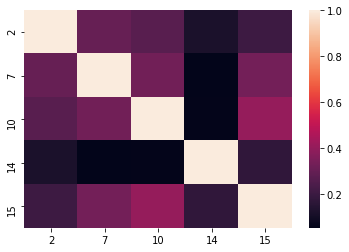

In [151]:
cc_corr = credit_card_data_copy.corr()
sns.heatmap(cc_corr, 
            xticklabels=cc_corr.columns.values,
            yticklabels=cc_corr.columns.values)

In [152]:
cc_corr[15].sort_values()

14    0.172766
2     0.207086
7     0.332728
10    0.406052
15    1.000000
Name: 15, dtype: float64

In [153]:
# transform categorical attributes to numeric values
encoder = LabelEncoder()
def obj_to_num(dataset):
    for col in dataset:
        if dataset[col].dtype == 'object':
            dataset[col] = encoder.fit_transform(dataset[col])
    return dataset

In [154]:
cc_data_copy_num = obj_to_num(credit_card_data_copy)

In [155]:
cc_data_copy_num.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,153,0.000,1,0,12,7,1.25,1,1,1,0,0,68,0,1
1,0,321,4.460,1,0,10,3,3.04,1,1,6,0,0,11,560,1
2,0,88,0.500,1,0,10,3,1.50,1,0,0,0,0,94,824,1
3,1,123,1.540,1,0,12,7,3.75,1,1,5,1,0,31,3,1
4,1,42,5.625,1,0,12,7,1.71,1,0,0,0,2,37,0,1


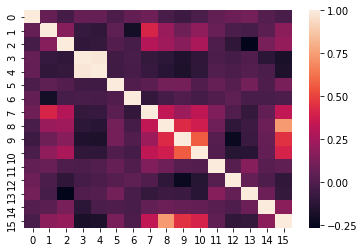

In [156]:
cc_corr = cc_data_copy_num.corr()
sns.heatmap(cc_corr, 
            xticklabels=cc_corr.columns.values,
            yticklabels=cc_corr.columns.values)

In [157]:
cc_corr[15].sort_values()

3    -0.179700
4    -0.169976
12   -0.100785
13   -0.092483
0    -0.019817
6    -0.011023
11    0.050011
5     0.123314
14    0.172766
1     0.178769
2     0.207086
7     0.332728
10    0.406052
9     0.451866
8     0.738829
15    1.000000
Name: 15, dtype: float64

In [158]:
cc_data_copy_num = cc_data_copy_num.drop([0, 6, 11, 13], axis=1)    #axis=1 indicates column
cc_data_copy_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 12 columns):
1     653 non-null int32
2     653 non-null float64
3     653 non-null int32
4     653 non-null int32
5     653 non-null int32
7     653 non-null float64
8     653 non-null int32
9     653 non-null int32
10    653 non-null int64
12    653 non-null int32
14    653 non-null int64
15    653 non-null int64
dtypes: float64(2), int32(7), int64(3)
memory usage: 48.5 KB


In [159]:
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [3, 4])],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                         # Leave the rest of the columns untouched
)

cc_nparray = np.array(ct.fit_transform(cc_data_copy_num))

In [160]:
# separate the dataset to training set and test set

# cc_nparray = cc_data_copy_num    #axis=1 indicates column
X, y = cc_nparray[:, 0:11], cc_nparray[:, 11] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [161]:
X_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [162]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(rescaledX_train)
X_test_pca = pca.transform(rescaledX_test)
explained_variance = pca.explained_variance_ratio_


In [164]:
# implement logistic regression
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(X_train_pca, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [165]:
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(X_test_pca)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(X_train_pca, y_train))

confusion_matrix(y_test, y_pred)

Accuracy of logistic regression classifier:  0.919908466819222


array([[203,   0],
       [ 13,   0]], dtype=int64)

In [166]:
explained_variance


array([0.40813891, 0.18779641])

In [167]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [168]:
y_test

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [169]:
rescaledX_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


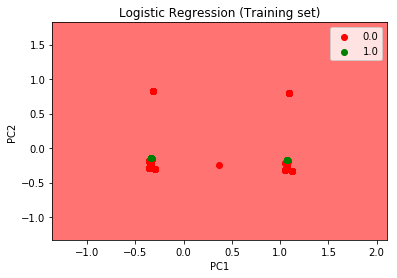

In [183]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train_pca, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, logreg.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.55, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


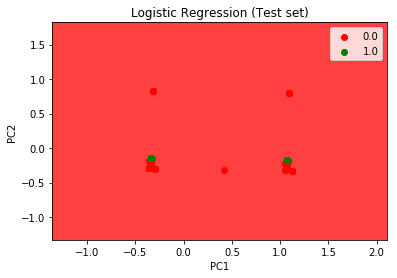

In [172]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test_pca, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, logreg.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

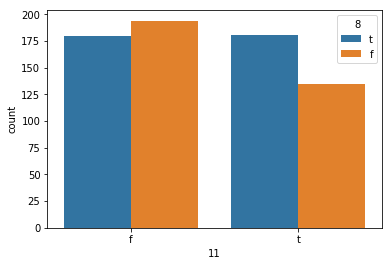

In [182]:
sns.countplot(x=11, hue=8, data=credit_card_data)